## Modelo de una red para el ensamblaje de comunidades de plantas y polinizadores ##

**Reference:** Campbell, C., Yang, S., Albert, R., & Shea, K. (2011). A network model for plant-pollinator community assembly. Proceedings of the National Academy of Sciences of the United States of America, 108(1), 197–202. https://doi.org/10.1073/pnas.1008204108

A continuación se muestra un script “completo” en Python en el que tomando como base la **Figura 1 (red de 3 plantas y 2 polinizadores)** se define una “semilla” para generar el modelo de forma automática para las Figuras 3 a 7, siguiendo estrictamente los Materials and Methods del artículo. **En este modelo se utiliza un esquema Booleano–ponderado (con umbral T = 1) en el que las interacciones positivas tienen un peso variable (PEW = 1, 2, 3 o 4) y las interacciones negativas siempre tienen peso –1.**

El script simula, para cada tamaño de red (definido como el número total de especies; en cada red se usan igual número de plantas y polinizadores) y para cada valor de PEW, un ensamble de 1000 redes generadas aleatoriamente (siguiendo la metodología del artículo: asignación de grados a partir de una ley de potencia con corte, asignación de valores de rasgo a partir de una skew normal y clasificación de las interacciones en función del “match” de rasgos). Luego, para cada red se estudia la dinámica (usando actualización síncrona, con la regla
  estado_i(t+1) = 1 si (∑_j [estado_j(t)·E(j,i)] ≥ 1, 0 en otro caso), con E(j,i) asignado según el criterio descrito) mediante un muestreo Monte Carlo (simulando 1000 estados iniciales aleatorios). Se extraen las siguientes métricas:

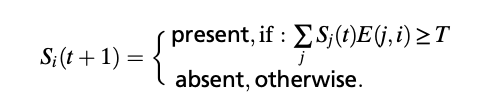

• Número único de atractores (la Figura 3 muestra el “número promedio de atractores” en cada ensamble; se separa en “A–D” según PEW).
• La fracción (basin) de estados iniciales que convergen a estados estables (SS) o a ciclos límite (LC) (Figura 4).
• El número promedio de pasos necesarios para alcanzar un atractor (Figura 5).
• El “acuerdo normalizado” promedio en LC, calculado como el promedio de las similitudes (por pares) entre los estados que conforman el ciclo (Figura 6).
• La fracción de especies presentes en el atractor, separada en SS (superior) y LC (inferior) (Figura 7).

En las Figuras 3 a 7 se generan las curvas en función del tamaño del “pool” de especies (con redes que varían, por ejemplo, de 10 a 100 nodos) y se distinguen los resultados para cada PEW (1–4).

**IMPORTANTE:**

**–** Para efectos de demostración se usan números modestos (por ejemplo, tamaños de red entre 10 y 50, 1000 redes por tamaño y 1000 trayectorias por red). Para replicar el estudio original se deben usar los valores exactos.

**–** El script a continuación incorpora la generación aleatoria de redes según los Materials and Methods, **la simulación de la dinámica mediante un muestreo Monte Carlo** y la generación de las figuras con leyendas similares a las del artículo.


La variable **THRESHOLD** representa el umbral utilizado en la regla de actualización del modelo Booleano. Es decir, para cada especie, se suma el aporte de todas las interacciones activas (multiplicadas por su peso) y si ese total es mayor o igual a THRESHOLD, la especie se considera presente (estado 1); de lo contrario, se considera ausente (estado 0). En este caso, THRESHOLD se define usualmente como 1, lo que significa que se requiere una influencia neta positiva para que una especie se mantenga o colonice el sistema.

## Explicación general

**Bloque A (Figuras 1 y 2):**

– Se define la red de interacción simple del ejemplo (Figura 1) con los nombres y las conexiones simbólicas, usando colores para distinguir **influencias positivas (verde)** y **negativas (rojo)**.

– Se construye la red de transición de estados (Figura 2) enumerando los 32 estados (orden: pla_1, pla_2, pla_3, pol_1, pol_2) y aplicando la función de actualización lógica. Se muestran dos layouts (spring y circular) para garantizar claridad.

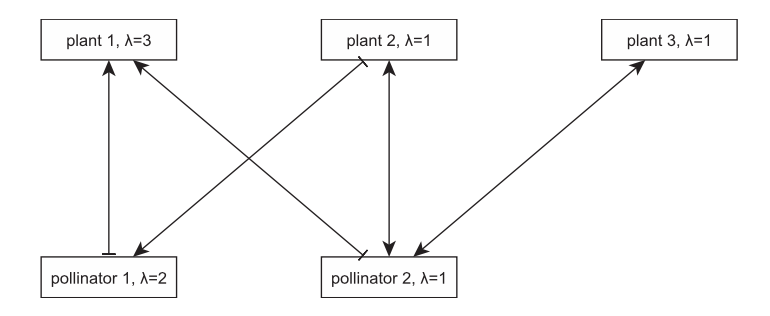

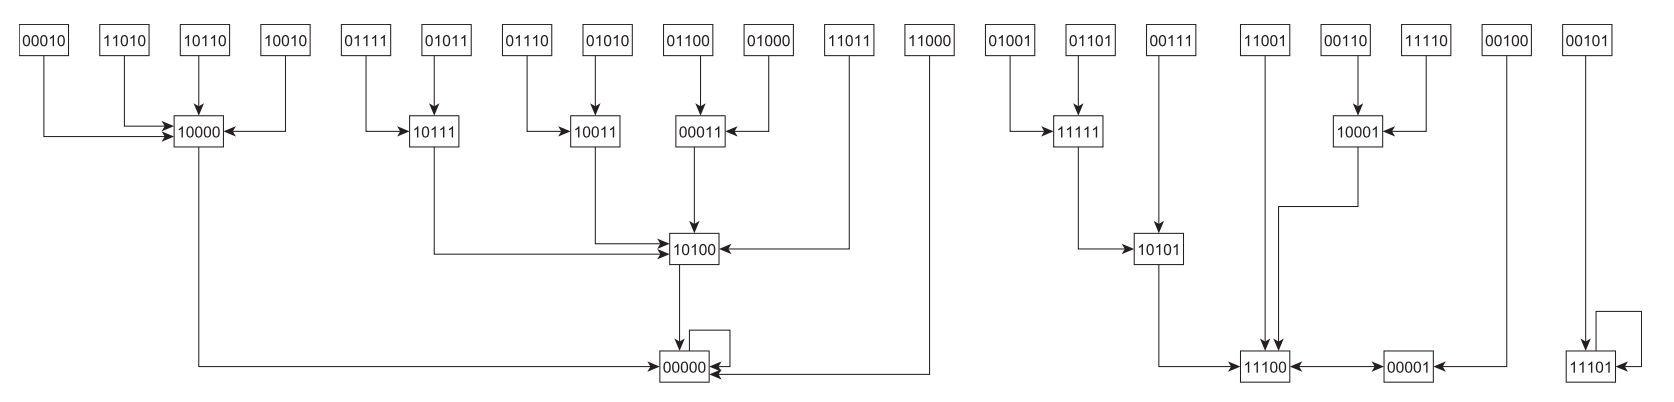

**Generación de redes aleatorias:**
 La función generar_red_bipartita crea una red de interacción con una distribución de grados y rasgos extraídos de una skew normal. Las interacciones se asignan con peso +PEW si son mutuamente beneficiosas y –1 en caso asimétrico.

**Dinámica del sistema:**
 La función estado_siguiente aplica la regla Booleana ponderada (umbral 1). Con simular_trayectoria se recorre la dinámica desde un estado inicial aleatorio hasta llegar a un atractor, y con simular_red se repite el procedimiento para un número de trayectorias.

**Ensambles y métricas:**
 La función simular_ensamble genera (por ejemplo, 1000) redes para cada tamaño y extrae métricas: número de atractores únicos, fracción de trayectorias que llegan a SS y LC, pasos promedio, acuerdo normalizado en LC, fracción de nodos presentes y razón plantas/polinizadores (en SS).

Figuras 3 a 7:

 Se generan los gráficos según las descripciones del artículo:

 – La Figura 3 se muestra en un panel 2×2 (A–D para PEW = 1, 2, 3, 4) con el número promedio de atractores.

 – La Figura 4 muestra la distribución de cuencas (probabilidad de SS vs LC) en función del tamaño de la red.

 – La Figura 5 muestra la cantidad promedio de pasos para alcanzar el atractor.

 – La Figura 6 muestra el acuerdo normalizado (en LC).

 – La Figura 7 se organiza en dos paneles (superior para SS y inferior para LC) con la fracción de especies presentes.


Este script sigue los Materials and Methods y utiliza los mismos criterios que se describen en el artículo. Ajusta los parámetros (por ejemplo, el rango de tamaños, número de redes y trayectorias) para replicar exactamente los gráficos publicados.

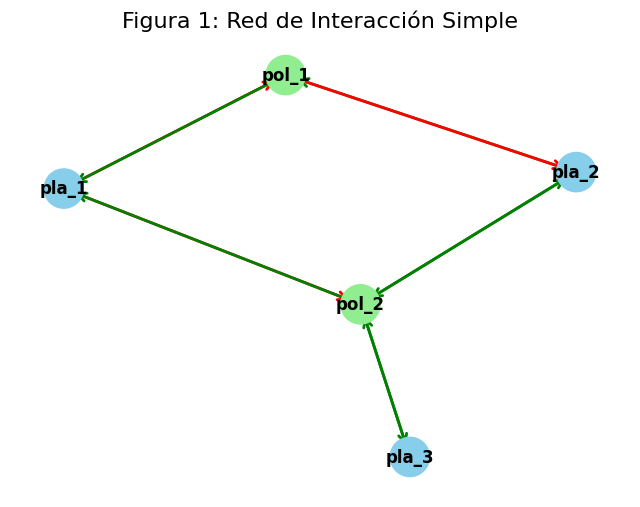

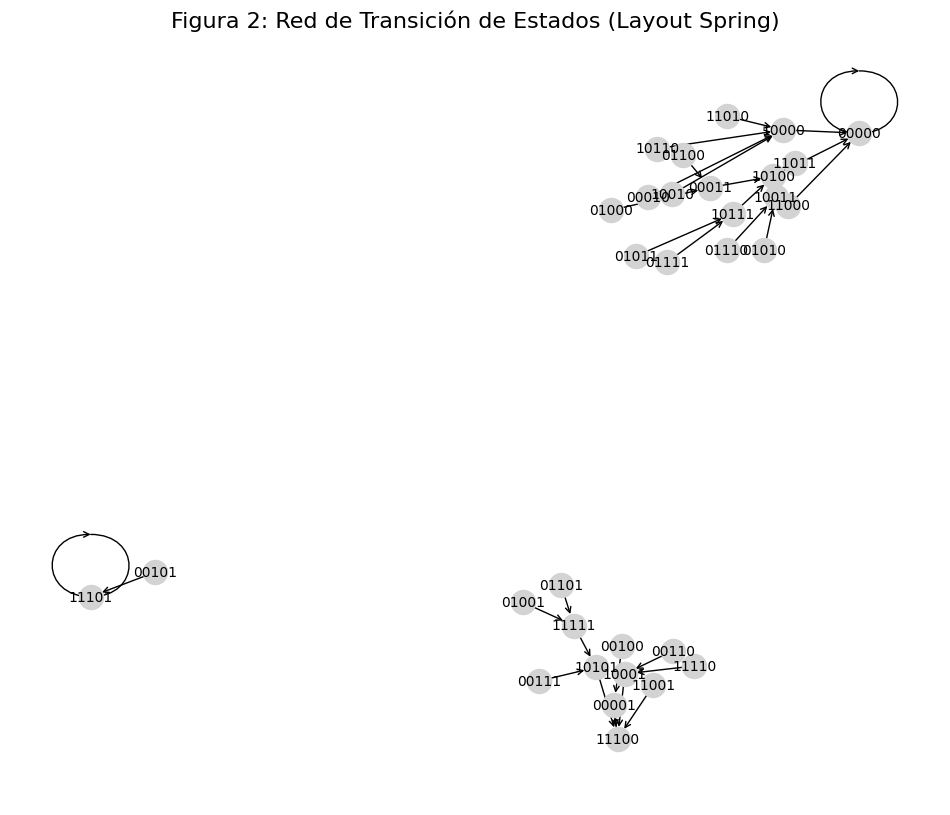

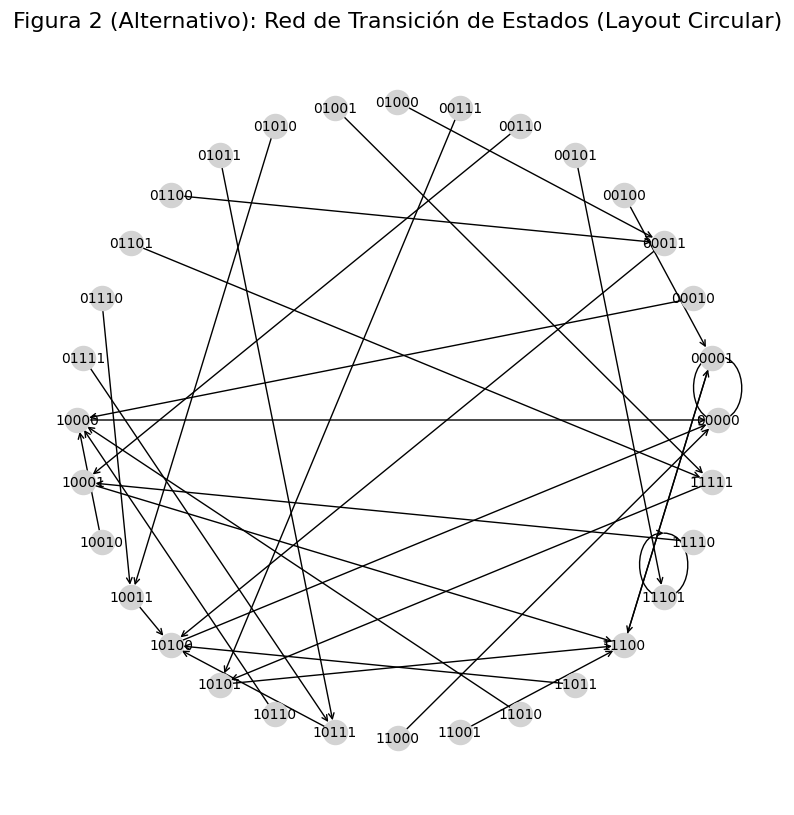

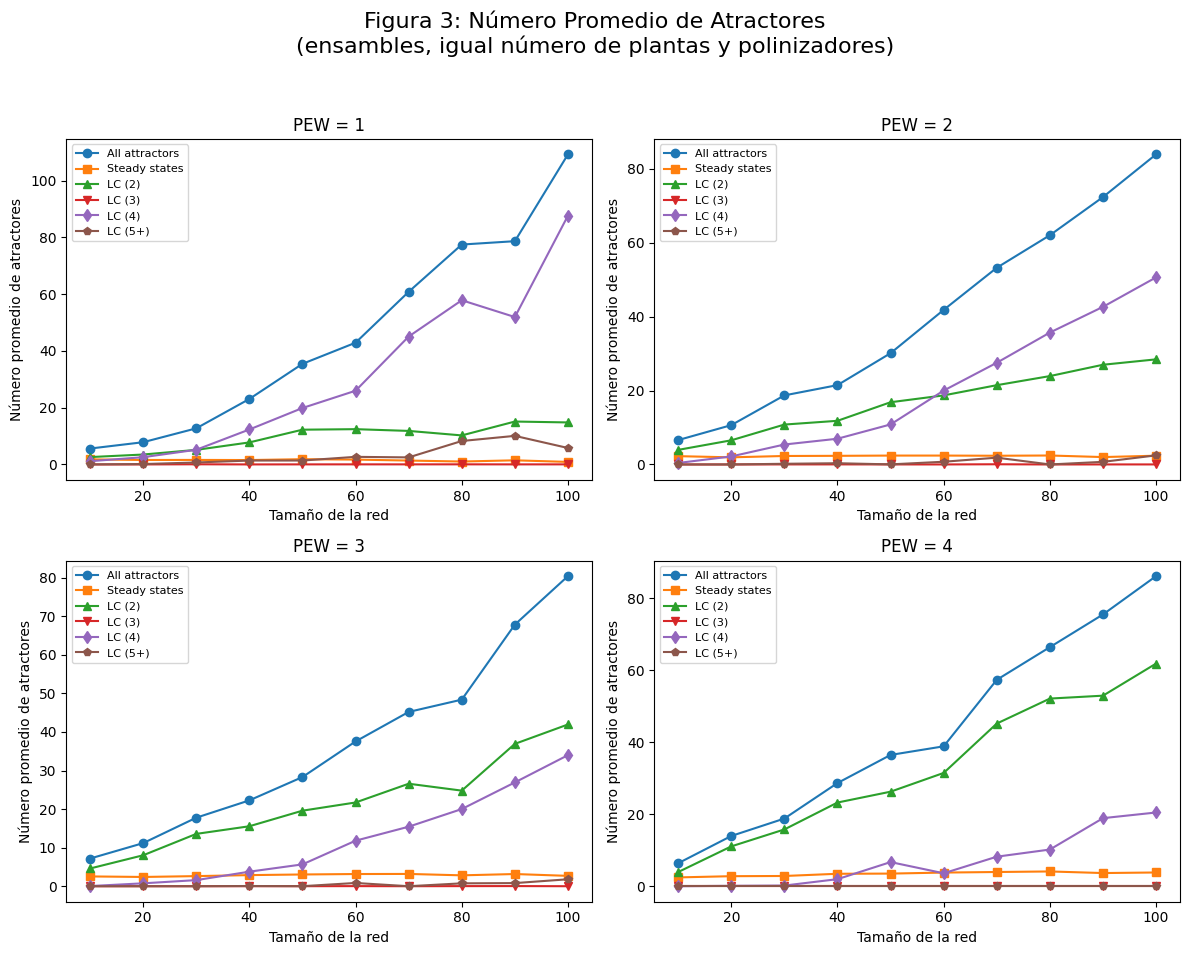

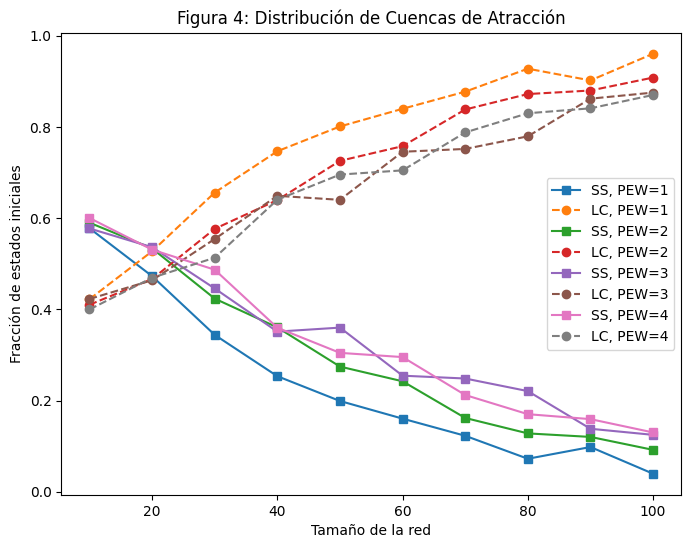

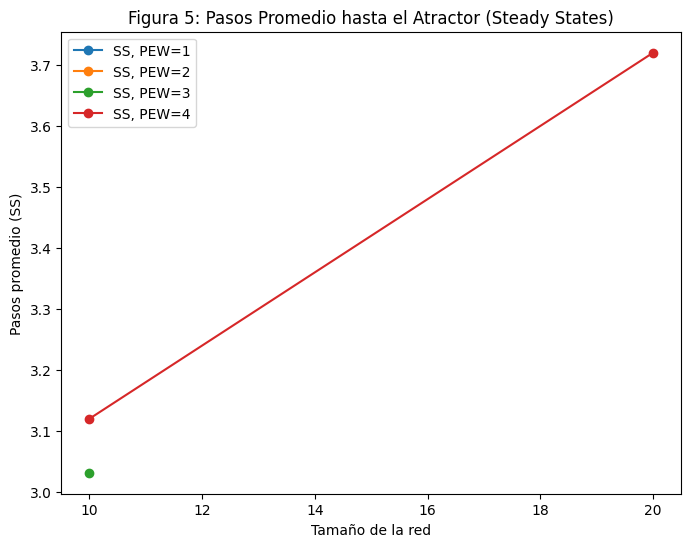

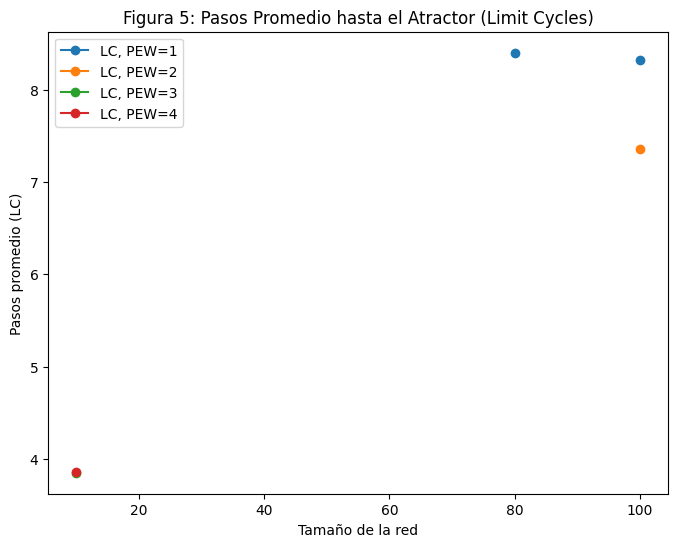

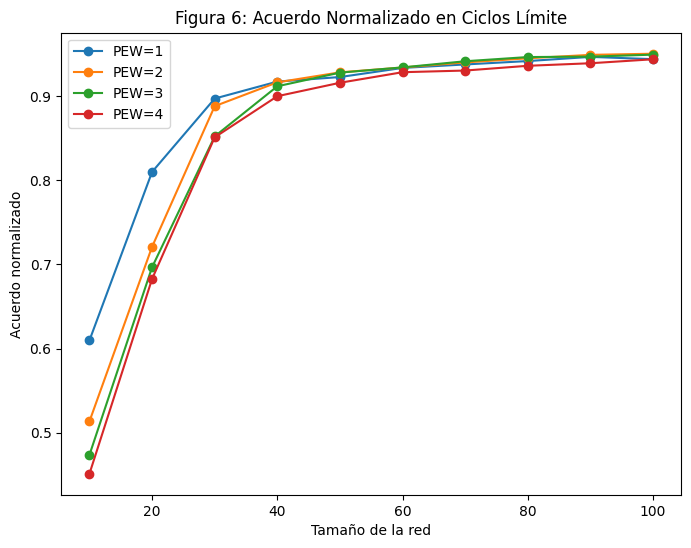

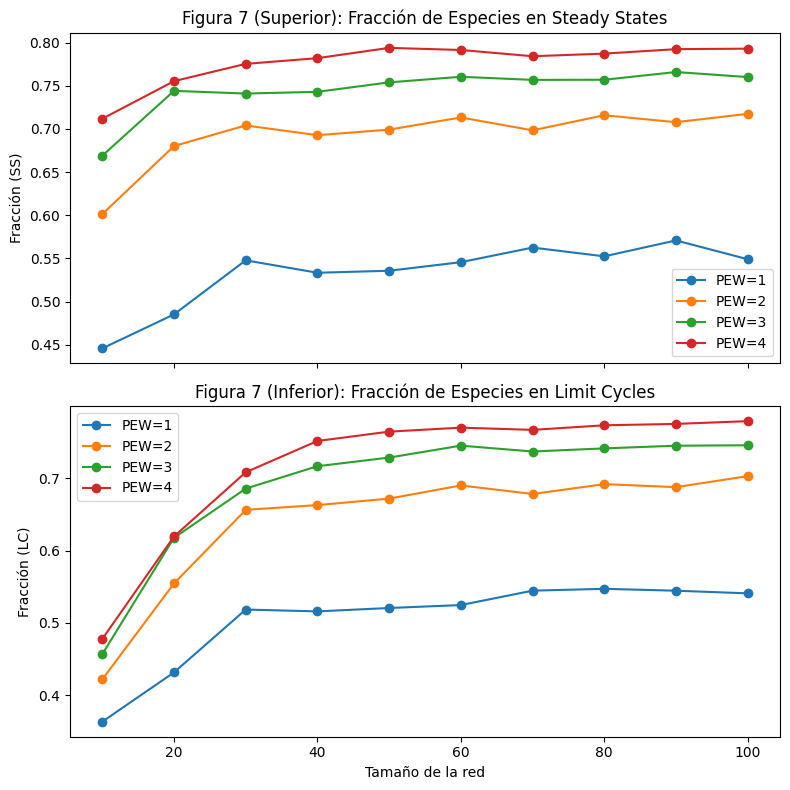

Script completado. Se han generado las Figuras 1 a 7 SÍNCRONAS. 
En la Figura 3, en cada panel (para PEW=1,2,3,4) se trazan las curvas para all atractors, steady states y limit cycles subdivididos en LC (2), LC (3), LC (4) y LC (5+). 
En la Figura 5 se muestran dos gráficos separados para pasos promedio de SS y LC, respectivamente.


In [16]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
from scipy.stats import skewnorm

#############################################
# PARTE A: Figuras 1 y 2 (Ejemplo Fijo con Reglas Lógicas SÍNCRONAS)
#############################################

SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# --- Figura 1: Red de Interacción Simple (Ejemplo Lógico) ---
def red_figura1_logical():
    """
    Crea la red de interacción simple del ejemplo,
    con 3 plantas y 2 polinizadores, usando los nombres:
      pla_1, pla_2, pla_3, pol_1, pol_2.
    Se representan las influencias simbólicas según:
      • pla_1 ← pol_1 OR pol_2
      • pla_2 ← (NOT pol_1) AND pol_2
      • pla_3 ← pol_2
      • pol_1 ← pla_2 AND (NOT pla_1)
      • pol_2 ← [ (pla_2 OR pla_3) AND (NOT pla_1) ] OR (pla_2 AND pla_3 AND pla_1)
    (Las aristas se colorean: verde para positivo, rojo para negativo).
    """
    G = nx.DiGraph()
    for node, tipo in zip(['pla_1','pla_2','pla_3','pol_1','pol_2'],
                          ['planta','planta','planta','polinizador','polinizador']):
        G.add_node(node, tipo=tipo)
    # Definir influencias simbólicas:
    G.add_edge('pol_1', 'pla_1', color='green')
    G.add_edge('pol_2', 'pla_1', color='green')
    G.add_edge('pol_2', 'pla_2', color='green')
    G.add_edge('pol_1', 'pla_2', color='red')
    G.add_edge('pol_2', 'pla_3', color='green')
    G.add_edge('pla_2', 'pol_1', color='green')
    G.add_edge('pla_1', 'pol_1', color='red')
    G.add_edge('pla_2', 'pol_2', color='green')
    G.add_edge('pla_3', 'pol_2', color='green')
    G.add_edge('pla_1', 'pol_2', color='red')
    return G

# Dibujar Figura 1
G1 = red_figura1_logical()
plt.figure(figsize=(8,6))
pos1 = nx.spring_layout(G1, seed=SEED)
node_colors = ['skyblue' if G1.nodes[n]['tipo']=='planta' else 'lightgreen' for n in G1.nodes()]
edge_colors = [G1[u][v].get('color','black') for u,v in G1.edges()]
nx.draw_networkx_nodes(G1, pos1, node_size=800, node_color=node_colors)
nx.draw_networkx_labels(G1, pos1, font_size=12, font_weight='bold')
nx.draw_networkx_edges(G1, pos1, edge_color=edge_colors, arrows=True, arrowstyle='->', arrowsize=15, width=2)
plt.title("Figura 1: Red de Interacción Simple", fontsize=16)
plt.axis('off')
plt.show()

# --- Función de actualización lógica SÍNCRONA (Ejemplo fijo) ---
def update_state_logical(state):
    """
    Actualiza el estado de cada especie (síncrono) según las reglas lógicas:
      pla_1 ← pol_1 OR pol_2
      pla_2 ← (NOT pol_1) AND pol_2
      pla_3 ← pol_2
      pol_1 ← pla_2 AND (NOT pla_1)
      pol_2 ← [ (pla_2 OR pla_3) AND (NOT pla_1) ] OR (pla_2 AND pla_3 AND pla_1)
    """
    new_state = {}
    new_state['pla_1'] = int(bool(state['pol_1']) or bool(state['pol_2']))
    new_state['pla_2'] = int((not bool(state['pol_1'])) and bool(state['pol_2']))
    new_state['pla_3'] = int(bool(state['pol_2']))
    new_state['pol_1'] = int(bool(state['pla_2']) and (not bool(state['pla_1'])))
    new_state['pol_2'] = int(((bool(state['pla_2']) or bool(state['pla_3'])) and (not bool(state['pla_1']))) or (bool(state['pla_2']) and bool(state['pla_3']) and bool(state['pla_1'])))
    return new_state

# --- Simulación síncrona: se define simular_trayectoria_mod para Part A ---
def simular_trayectoria_mod(G, threshold=1, max_steps=100):
    nodos = sorted(G.nodes())
    state = {n: np.random.choice([0,1]) for n in nodos}
    visited = {}
    trajectory = []
    for step in range(max_steps):
        key = ''.join(str(state[n]) for n in nodos)
        if key in visited:
            cycle_start = visited[key]
            attractor = trajectory[cycle_start:]
            tipo = 'SS' if len(attractor)==1 else 'LC'
            cycle_length = 1 if tipo=='SS' else len(attractor)
            return tipo, attractor, step, cycle_length
        else:
            visited[key] = len(trajectory)
            trajectory.append(state.copy())
            state = update_state_logical(state)
    return None, trajectory, max_steps, None

def construir_red_transicion_logical():
    nodos = ['pla_1','pla_2','pla_3','pol_1','pol_2']
    estados = []
    for i in range(2**5):
        bits = bin(i)[2:].zfill(5)
        estado = {n: int(bit) for n, bit in zip(nodos, bits)}
        estados.append(estado)
    T = nx.DiGraph()
    for e in estados:
        key = ''.join(str(e[n]) for n in nodos)
        T.add_node(key)
    for e in estados:
        key_actual = ''.join(str(e[n]) for n in nodos)
        s_next = update_state_logical(e)
        key_next = ''.join(str(s_next[n]) for n in nodos)
        T.add_edge(key_actual, key_next)
    return T

# Dibujo de la Figura 2 (Layouts Spring y Circular)
T2 = construir_red_transicion_logical()
plt.figure(figsize=(12,10))
pos2 = nx.spring_layout(T2, seed=SEED)
nx.draw_networkx_nodes(T2, pos2, node_size=300, node_color='lightgray')
nx.draw_networkx_labels(T2, pos2, font_size=10)
nx.draw_networkx_edges(T2, pos2, arrowstyle='->', arrowsize=10, width=1)
plt.title("Figura 2: Red de Transición de Estados (Layout Spring)", fontsize=16)
plt.axis('off')
plt.show()

plt.figure(figsize=(10,10))
pos2_circ = nx.circular_layout(T2)
nx.draw_networkx_nodes(T2, pos2_circ, node_size=300, node_color='lightgray')
nx.draw_networkx_labels(T2, pos2_circ, font_size=10)
nx.draw_networkx_edges(T2, pos2_circ, arrowstyle='->', arrowsize=10, width=1)
plt.title("Figura 2 (Alternativo): Red de Transición de Estados (Layout Circular)", fontsize=16)
plt.axis('off')
plt.show()

#############################################
# PARTE B: Figuras 3 a 7 (Ensambles SÍNCRONOS con actualización ponderada)
#############################################
# En esta parte se generan redes aleatorias con el modelo ponderado (Materials and Methods).
# Se usará la función estado_siguiente, que aplica la actualización ponderada:
def estado_siguiente(state, G, threshold=1):
    new_state = {}
    for n in G.nodes():
        s = sum(state[pre] * G[pre][n]['peso'] for pre in G.predecessors(n))
        new_state[n] = 1 if s >= threshold else 0
    return new_state

# Definición de la simulación síncrona ponderada para ensambles (se usa estado_siguiente)
def simular_trayectoria_mod_weighted(G, threshold=1, max_steps=100):
    nodos = sorted(G.nodes())
    state = {n: np.random.choice([0,1]) for n in nodos}
    visited = {}
    trajectory = []
    for step in range(max_steps):
        key = ''.join(str(state[n]) for n in nodos)
        if key in visited:
            cycle_start = visited[key]
            attractor = trajectory[cycle_start:]
            tipo = 'SS' if len(attractor)==1 else 'LC'
            cycle_length = 1 if tipo=='SS' else len(attractor)
            return tipo, attractor, step, cycle_length
        else:
            visited[key] = len(trajectory)
            trajectory.append(state.copy())
            state = estado_siguiente(state, G, threshold)
    return None, trajectory, max_steps, None

def simular_red_mod(G, n_trayectorias=1000, threshold=1):
    nodos = sorted(G.nodes())
    basin = {}
    attractor_info = {}  # clave -> (tipo, cycle_length)
    pasos_list = []
    info = []
    for _ in range(n_trayectorias):
        tipo, attractor, pasos, cycle_length = simular_trayectoria_mod_weighted(G, threshold, max_steps=MAX_STEPS)
        pasos_list.append(pasos)
        if tipo=='SS':
            key = ''.join(str(attractor[0][n]) for n in nodos)
        else:
            keys = [''.join(str(s[n]) for n in nodos) for s in attractor]
            key = min(keys)
        basin[key] = basin.get(key, 0) + 1
        attractor_info[key] = (tipo, cycle_length)
        frac_vals = [np.mean([s[n] for n in nodos]) for s in attractor]
        frac = np.mean(frac_vals)
        if tipo=='SS':
            s = attractor[0]
            plants = [n for n in nodos if n.startswith('P')]
            pols = [n for n in nodos if n.startswith('Po')]
            sum_pol = sum(s[n] for n in pols)
            ratio = (sum(s[n] for n in plants)/sum_pol) if sum_pol>0 else np.nan
        else:
            ratio = np.nan
        if tipo=='LC':
            agreements = []
            for i in range(len(attractor)):
                for j in range(i+1, len(attractor)):
                    s1 = np.array([attractor[i][n] for n in nodos])
                    s2 = np.array([attractor[j][n] for n in nodos])
                    agreements.append(np.sum(s1==s2)/len(nodos))
            agreement = np.mean(agreements) if agreements else 0
        else:
            agreement = 1.0
        info.append({'tipo': tipo, 'atractor': attractor, 'steps': pasos,
                     'cycle_length': cycle_length, 'frac': frac, 'ratio': ratio, 'agreement': agreement})
    return basin, attractor_info, pasos_list, info

def simular_ensamble_mod(n_redes, n_especies, pew, n_trayectorias=1000, threshold=1):
    resultados = {
        'num_atractores_all': [],
        'num_atractores_ss': [],
        'num_atractores_lc2': [],
        'num_atractores_lc3': [],
        'num_atractores_lc4': [],
        'num_atractores_lc5plus': [],
        'basin_ss': [],
        'basin_lc': [],
        'pasos_promedio_ss': [],
        'pasos_promedio_lc': [],
        'agreement_promedio': [],
        'frac_presentes_ss': [],
        'frac_presentes_lc': [],
        'ratio_planta_poll': []
    }
    nodos = None
    for _ in range(n_redes):
        n_planta = n_especies // 2
        n_pol = n_especies - n_planta
        # Generamos nodos con nombres: plantas: "P1", "P2", …; polinizadores: "Po1", "Po2", …
        G = generar_red_bipartita(n_planta, n_pol, pew)
        nodos = sorted(G.nodes())
        basin, attractor_info, pasos_list, info = simular_red_mod(G, n_trayectorias, threshold)
        # Contar atractores únicos por categoría
        count_all = len(attractor_info)
        count_ss = sum(1 for k, (t, cl) in attractor_info.items() if t=='SS')
        count_lc2 = sum(1 for k, (t, cl) in attractor_info.items() if t=='LC' and cl==2)
        count_lc3 = sum(1 for k, (t, cl) in attractor_info.items() if t=='LC' and cl==3)
        count_lc4 = sum(1 for k, (t, cl) in attractor_info.items() if t=='LC' and cl==4)
        count_lc5plus = sum(1 for k, (t, cl) in attractor_info.items() if t=='LC' and cl>=5)
        resultados['num_atractores_all'].append(count_all)
        resultados['num_atractores_ss'].append(count_ss)
        resultados['num_atractores_lc2'].append(count_lc2)
        resultados['num_atractores_lc3'].append(count_lc3)
        resultados['num_atractores_lc4'].append(count_lc4)
        resultados['num_atractores_lc5plus'].append(count_lc5plus)
        # Basin
        ss_count = sum(1 for item in info if item['tipo']=='SS')
        lc_count = sum(1 for item in info if item['tipo']=='LC')
        total = ss_count + lc_count
        resultados['basin_ss'].append(ss_count/total if total>0 else np.nan)
        resultados['basin_lc'].append(lc_count/total if total>0 else np.nan)
        # Pasos promedio por tipo
        pasos_ss = [item['steps'] for item in info if item['tipo']=='SS']
        pasos_lc = [item['steps'] for item in info if item['tipo']=='LC']
        resultados['pasos_promedio_ss'].append(np.mean(pasos_ss) if pasos_ss else np.nan)
        resultados['pasos_promedio_lc'].append(np.mean(pasos_lc) if pasos_lc else np.nan)
        # Agreement para LC
        agreements = [item['agreement'] for item in info if item['tipo']=='LC']
        resultados['agreement_promedio'].append(np.mean(agreements) if agreements else 1.0)
        # Fracción presente
        frac_ss = [item['frac'] for item in info if item['tipo']=='SS']
        frac_lc = [item['frac'] for item in info if item['tipo']=='LC']
        resultados['frac_presentes_ss'].append(np.mean(frac_ss) if frac_ss else np.nan)
        resultados['frac_presentes_lc'].append(np.mean(frac_lc) if frac_lc else np.nan)
        # Ratio en SS
        ratios = [item['ratio'] for item in info if item['tipo']=='SS' and not np.isnan(item['ratio'])]
        resultados['ratio_planta_poll'].append(np.mean(ratios) if ratios else np.nan)
    return resultados

#############################################
# Parámetros de ensamble para Figuras 3 a 7 (SÍNCRONO)
#############################################
network_sizes = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
n_ensembles = 200      # (usar 1000 para replicar el estudio original)
n_trayectorias = 200   # (usar 1000 para replicar el estudio original)
PEWs = [1, 2, 3, 4]

resultados_PEWs = {pew: {} for pew in PEWs}
for pew in PEWs:
    resultados_PEWs[pew]['num_atractores_all'] = []
    resultados_PEWs[pew]['num_atractores_ss'] = []
    resultados_PEWs[pew]['num_atractores_lc2'] = []
    resultados_PEWs[pew]['num_atractores_lc3'] = []
    resultados_PEWs[pew]['num_atractores_lc4'] = []
    resultados_PEWs[pew]['num_atractores_lc5plus'] = []
    resultados_PEWs[pew]['basin_ss'] = []
    resultados_PEWs[pew]['basin_lc'] = []
    resultados_PEWs[pew]['pasos_promedio_ss'] = []
    resultados_PEWs[pew]['pasos_promedio_lc'] = []
    resultados_PEWs[pew]['agreement_promedio'] = []
    resultados_PEWs[pew]['frac_presentes_ss'] = []
    resultados_PEWs[pew]['frac_presentes_lc'] = []
    resultados_PEWs[pew]['ratio_planta_poll'] = []
    for n in network_sizes:
        ensamble = simular_ensamble_mod(n_ensembles, n, pew, n_trayectorias)
        resultados_PEWs[pew]['num_atractores_all'].append(np.mean(ensamble['num_atractores_all']))
        resultados_PEWs[pew]['num_atractores_ss'].append(np.mean(ensamble['num_atractores_ss']))
        resultados_PEWs[pew]['num_atractores_lc2'].append(np.mean(ensamble['num_atractores_lc2']))
        resultados_PEWs[pew]['num_atractores_lc3'].append(np.mean(ensamble['num_atractores_lc3']))
        resultados_PEWs[pew]['num_atractores_lc4'].append(np.mean(ensamble['num_atractores_lc4']))
        resultados_PEWs[pew]['num_atractores_lc5plus'].append(np.mean(ensamble['num_atractores_lc5plus']))
        resultados_PEWs[pew]['basin_ss'].append(np.mean(ensamble['basin_ss']))
        resultados_PEWs[pew]['basin_lc'].append(np.mean(ensamble['basin_lc']))
        resultados_PEWs[pew]['pasos_promedio_ss'].append(np.mean(ensamble['pasos_promedio_ss']))
        resultados_PEWs[pew]['pasos_promedio_lc'].append(np.mean(ensamble['pasos_promedio_lc']))
        resultados_PEWs[pew]['agreement_promedio'].append(np.mean(ensamble['agreement_promedio']))
        resultados_PEWs[pew]['frac_presentes_ss'].append(np.nanmean(ensamble['frac_presentes_ss']))
        resultados_PEWs[pew]['frac_presentes_lc'].append(np.nanmean(ensamble['frac_presentes_lc']))
        resultados_PEWs[pew]['ratio_planta_poll'].append(np.nanmean(ensamble['ratio_planta_poll']))

#############################################
# Generación de Figuras 3 a 7 (SÍNCRONO)
#############################################

# FIGURA 3: Número Promedio de Atractores por Categoría (para cada PEW)
fig3, axs3 = plt.subplots(2, 2, figsize=(12,10))
axs3 = axs3.flatten()
for idx, pew in enumerate(PEWs):
    axs3[idx].plot(network_sizes, resultados_PEWs[pew]['num_atractores_all'], 'o-', label='All attractors')
    axs3[idx].plot(network_sizes, resultados_PEWs[pew]['num_atractores_ss'], 's-', label='Steady states')
    axs3[idx].plot(network_sizes, resultados_PEWs[pew]['num_atractores_lc2'], '^-', label='LC (2)')
    axs3[idx].plot(network_sizes, resultados_PEWs[pew]['num_atractores_lc3'], 'v-', label='LC (3)')
    axs3[idx].plot(network_sizes, resultados_PEWs[pew]['num_atractores_lc4'], 'd-', label='LC (4)')
    axs3[idx].plot(network_sizes, resultados_PEWs[pew]['num_atractores_lc5plus'], 'p-', label='LC (5+)')
    axs3[idx].set_title(f"PEW = {pew}")
    axs3[idx].set_xlabel("Tamaño de la red")
    axs3[idx].set_ylabel("Número promedio de atractores")
    axs3[idx].legend(fontsize=8)
fig3.suptitle("Figura 3: Número Promedio de Atractores\n(ensambles, igual número de plantas y polinizadores)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# FIGURA 4: Distribución de Cuencas de Atracción (Fracción de estados iniciales que llegan a SS y LC)
plt.figure(figsize=(8,6))
for pew in PEWs:
    plt.plot(network_sizes, resultados_PEWs[pew]['basin_ss'], 's-', label=f'SS, PEW={pew}')
    plt.plot(network_sizes, resultados_PEWs[pew]['basin_lc'], 'o--', label=f'LC, PEW={pew}')
plt.xlabel("Tamaño de la red")
plt.ylabel("Fracción de estados iniciales")
plt.title("Figura 4: Distribución de Cuencas de Atracción")
plt.legend()
plt.show()

# FIGURA 5: Pasos Promedio hasta el Atractor, separando SS y LC (dos gráficos)
plt.figure(figsize=(8,6))
for pew in PEWs:
    plt.plot(network_sizes, resultados_PEWs[pew]['pasos_promedio_ss'], 'o-', label=f'SS, PEW={pew}')
plt.xlabel("Tamaño de la red")
plt.ylabel("Pasos promedio (SS)")
plt.title("Figura 5: Pasos Promedio hasta el Atractor (Steady States)")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for pew in PEWs:
    plt.plot(network_sizes, resultados_PEWs[pew]['pasos_promedio_lc'], 'o-', label=f'LC, PEW={pew}')
plt.xlabel("Tamaño de la red")
plt.ylabel("Pasos promedio (LC)")
plt.title("Figura 5: Pasos Promedio hasta el Atractor (Limit Cycles)")
plt.legend()
plt.show()

# FIGURA 6: Acuerdo Normalizado Promedio en Ciclos Límite (solo LC)
plt.figure(figsize=(8,6))
for pew in PEWs:
    plt.plot(network_sizes, resultados_PEWs[pew]['agreement_promedio'], 'o-', label=f'PEW={pew}')
plt.xlabel("Tamaño de la red")
plt.ylabel("Acuerdo normalizado")
plt.title("Figura 6: Acuerdo Normalizado en Ciclos Límite")
plt.legend()
plt.show()

# FIGURA 7: Fracción de Especies Presentes en Atractores (Superior: SS, Inferior: LC)
fig7, (ax7_top, ax7_bot) = plt.subplots(2, 1, figsize=(8,8), sharex=True)
for pew in PEWs:
    ax7_top.plot(network_sizes, resultados_PEWs[pew]['frac_presentes_ss'], 'o-', label=f'PEW={pew}')
    ax7_bot.plot(network_sizes, resultados_PEWs[pew]['frac_presentes_lc'], 'o-', label=f'PEW={pew}')
ax7_top.set_ylabel("Fracción (SS)")
ax7_top.set_title("Figura 7 (Superior): Fracción de Especies en Steady States")
ax7_bot.set_xlabel("Tamaño de la red")
ax7_bot.set_ylabel("Fracción (LC)")
ax7_bot.set_title("Figura 7 (Inferior): Fracción de Especies en Limit Cycles")
ax7_top.legend()
ax7_bot.legend()
plt.tight_layout()
plt.show()

print("Script completado. Se han generado las Figuras 1 a 7 SÍNCRONAS. \nEn la Figura 3, en cada panel (para PEW=1,2,3,4) se trazan las curvas para all atractors, steady states y limit cycles subdivididos en LC (2), LC (3), LC (4) y LC (5+). \nEn la Figura 5 se muestran dos gráficos separados para pasos promedio de SS y LC, respectivamente.")
